In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

# Report Outline:

1. Data exploration
2. A baseline for the regression task
3. Predicting EGFR potency using a finetuned GraphGPS model

# 1. Data exploration

In [3]:
data = pd.read_csv("../datasets/EGFR/raw/EGFR_compounds_lipinsky.csv", index_col=0)
data.head()

,molecule_chembl_id,IC50,units,smiles,pIC50,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
0,CHEMBL63786,0.003,nM,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,349.021459,3,1,5.2891,True
1,CHEMBL35820,0.006,nM,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,387.058239,5,1,4.9333,True
2,CHEMBL53711,0.006,nM,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,343.043258,5,1,3.5969,True
3,CHEMBL66031,0.008,nM,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910,339.011957,4,2,4.0122,True
4,CHEMBL53753,0.008,nM,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910,329.027607,5,2,3.5726,True


First I want to know which columns contain relevant information and what they represent. On first glance it seems like the `units` and `ro5_fulfulled` columns contain the same values for all rows. If this is true, we can ignore these columns. 

In [4]:
print(data["units"].unique())
print(data["ro5_fulfilled"].unique())

['nM']
[ True]


`molecule_chembl_id`: the identifier of the molecule in the ChEMBL dataset (bioactive molecules with drug-like properties). 

`IC50`: the amount of substance needed to inhibit a process (*in vitro*) by 50%  
`pIC50`: -log10(IC50)

`smiles`: [SMILES strings](https://docs.eyesopen.com/toolkits/python/glossary.html#term-SMARTS) represent a molecule by describing its molecular graph. This can be used to build a molecule graph (e.g. for PyTorch Geometric). Alternatively, 2D molecular descriptors (e.g. structural keys) can be used. Strutural keys such as MACCS keys are binary bit strings where each bit represents a pre-defined feature (e.g. substructure/fragment). These keys can compared in a similar manner as embeddings, and similarity between two molecules can be computed using the Hamming distance. 

The following features affect the absorption and permeation properties of the molecule, which are important for evaluating the molecule as a drug candidate, but are unlikely to affect the potency value. I would include them in a more general model where the aim is to predict the general potential of the molecule as a drug, but not in the current task, where I am only interested in predicting pIC50. 

`molecular weight`: The [Lipinsky rule of 5](https://www.sciencedirect.com/science/article/pii/S0169409X96004231) states that poor absorption or permeation is more likely when the molecular weight is over 500

`n_hba`: number of H-bond acceptors. The Rule of 5 applies when there are more than 10 H-bond acceptors

`n_hbd`: number of H-bond donors. The Rule of 5 applies when there are more than 5 H-bond donors. 

`logp`: The Rule of 5 applies when LogP is over 5. 

## Data distribution

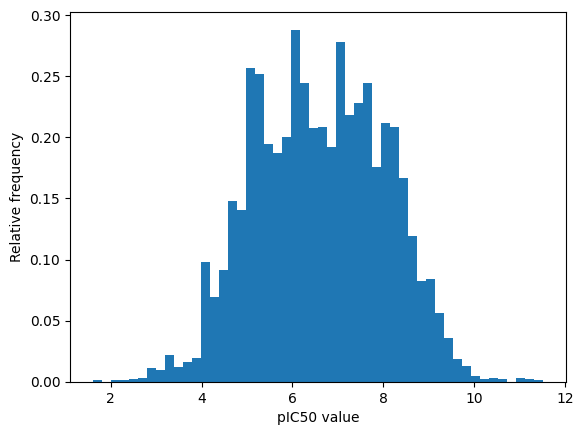

In [6]:
pIC50 = data["pIC50"].to_numpy()
plt.hist(pIC50, bins=50, density=True)
plt.xlabel("pIC50 value")
plt.ylabel("Relative frequency")
plt.show()

The dataset is relatively evenly distributed, the values we are interested in, pIC50 > 8 are not in the extreme tail end of the distribution, and there are no gaps in the data. 

# 2. A baseline for the regression task

Even though we are asked to predict whether compounds have a pIC50 > 8, I believe framing this as a regression task which outputs the pIC50 value is more appropriate beceause:

1. pIC50 is a continous variable
2. I cannot think of a reason which would make compounds with pIC50 slighly higher than 8 *categorically different* from compounds with pIC50 slightly lower than 8. Therefore I don't think it makes sense to build a classification model which would spend more resources on learning the slight differences between molecules with pIC50 $\approx 8$, and lose the advantage of a linear model which can learn from all the data. However, if this assumption is wrong, and there is a reason for an absolute cut-off at pIC50 = 8, a classifcation model would be more appropriate.  

I first use a random forest regressor to establish a baseline for the problem, with which I will compare the results of my main approach (finetuning using a pre-trained [GraphGPS](https://arxiv.org/abs/2205.12454) model). I chose the random forest regressor because we do not require extrapolation, and assumptions about no co-linearity can be relaxed with the random forest model (since the MACCS bits do not necessarily contain independent information). 

For this baseline model, I will encode the SMILES strings as MACCS structural keys, as in the [cheminfomatics tutorial](https://projects.volkamerlab.org/teachopencadd/talktorials/T007_compound_activity_machine_learning.html). In this section, the SMILES strings are converted, each bit of the MACCS key is treated as an independent variable, and the test-train split is done. 

In [28]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV
from rdkit import Chem
from rdkit.Chem import MACCSkeys

In [16]:
def smiles_to_maccs(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return list(MACCSkeys.GenMACCSKeys(mol))

In [18]:
data["maccs"] = data["smiles"].apply(smiles_to_maccs)

In [22]:
X = pd.DataFrame(data["maccs"].to_list(), columns=["maccs_{0}".format(i) for i in range(167)])
X.head()

,maccs_0,maccs_1,maccs_2,maccs_3,maccs_4,maccs_5,maccs_6,maccs_7,maccs_8,maccs_9,...,maccs_157,maccs_158,maccs_159,maccs_160,maccs_161,maccs_162,maccs_163,maccs_164,maccs_165,maccs_166
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,1,1,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,1,1,1,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,1,1,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,1,1,1,0,1,0


In [26]:
y = data["pIC50"]

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Next I set up the model and performed a randomized hyperparameter search using cross validation

In [45]:
model = RandomForestRegressor(n_estimators=100)
params = {
    "max_depth": [2, 3, None], # default None
    "max_leaf_nodes": [10, 20, None], # default None
    "min_samples_split": [2, 10], # default 2
    "max_features": ["sqrt", None], # default None=n_features
    "min_samples_leaf":[1, 2, 5], # default is 1
    "n_estimators": [100, 200], # default 100
}

clf = RandomizedSearchCV(model, params, scoring='neg_mean_absolute_error', n_iter=20)
clf.fit(X_train,y_train)

RandomizedSearchCV(estimator=RandomForestRegressor(), n_iter=20,
                   param_distributions={'max_depth': [2, 3, None],
                                        'max_features': ['sqrt', None],
                                        'max_leaf_nodes': [10, 20, None],
                                        'min_samples_leaf': [1, 2, 5],
                                        'min_samples_split': [2, 10],
                                        'n_estimators': [100, 200]},
                   scoring='neg_mean_absolute_error')

In [46]:
results = pd.DataFrame(clf.cv_results_)
results = results.sort_values("rank_test_score")
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_leaf_nodes,param_max_features,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
14,3.027456,0.032606,0.021527,0.000220,200,2,2,None,None,None,"{'n_estimators': 200, 'min_samples_split': 2, ...",-0.669586,-0.652911,-0.672031,-0.673883,-0.666342,-0.666950,0.007461,1
2,0.763073,0.005599,0.005395,0.000053,100,2,2,20,None,None,"{'n_estimators': 100, 'min_samples_split': 2, ...",-0.826696,-0.832543,-0.844389,-0.837431,-0.821114,-0.832435,0.008112,2
9,0.763131,0.005483,0.005491,0.000093,100,10,1,20,None,None,"{'n_estimators': 100, 'min_samples_split': 10,...",-0.822666,-0.829633,-0.848024,-0.842652,-0.821508,-0.832897,0.010668,3
7,1.527134,0.017367,0.009791,0.000083,200,2,2,20,None,None,"{'n_estimators': 200, 'min_samples_split': 2, ...",-0.824227,-0.833769,-0.845683,-0.838709,-0.822198,-0.832917,0.008805,4
0,0.607163,0.011772,0.004860,0.000074,100,2,2,10,None,None,"{'n_estimators': 100, 'min_samples_split': 2, ...",-0.871958,-0.877605,-0.894806,-0.881691,-0.866633,-0.878539,0.009597,5


I build a model using the best hyperparameters found, and apply it to the test set.

In [48]:
results["params"][14]

{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_leaf_nodes': None,
 'max_features': None,
 'max_depth': None}

In [49]:
model_best = RandomForestRegressor(n_estimators=200, min_samples_split=2, min_samples_leaf=2, max_leaf_nodes=None, max_features=None, max_depth=None)
model_best.fit(X_train, y_train)
y_pred = model_best.predict(X_test)
mae = np.mean(np.abs(y_pred-y_test))
print("Mean absolute error: {0}".format(mae))

Mean absolute error: 0.6565125764572766


# 3. Prediction using a finetuned GraphGPS model

The main model I used for the prediction task is the pretrained GPS-deep from [GraphGPS](https://github.com/rampasek/GraphGPS/tree/main). The model was trained on the PCQM4Mv2 dataset from OGB (predicting the HOMO-LUMO energy gap from 2D molecular graphs). I chose this model as I wanted to learn more about it after seeing its performance on benchmark datasets, and as the EGFR dataset is small, I wanted to leverage the power of a strong model trained on a much larger dataset. I had also not worked with the GraphGym platform before, and wanted to become more familiar with it. 


In order to finetune the model on the EGFR dataset, I implemented the following steps (links to code changes included):

1. Implemented a custom [dataset class](https://github.com/tz545/EGFR-detection-GraphGPS/blob/main/EGFR_addons/dataset_creation.py) which takes the SMILES strings from the csv file and converts them into graphs using the OGB encodings. 
2. Modified the [master loader function](https://github.com/tz545/EGFR-detection-GraphGPS/blob/main/graphgps/loader/master_loader.py) to extend the config file options and allow loading the EGFR dataset 
3. Added a [config file](https://github.com/tz545/EGFR-detection-GraphGPS/blob/main/configs/GPS/EGFR-finetune.yaml) for finetuning, with hyperparameters taken from the PCQM4Mv2 training runs. 
4. Added [unit tests](https://github.com/tz545/EGFR-detection-GraphGPS/tree/main/EGFR_addons/tests) for my dataset class. Unit tests should be run from the EGFR_addons directory using `python -m pytest` (given more time, I would have ideally used the same `unittest` library as the original codebase, and combined my unit tests in the same directory).

While setting up the finetuning, I also noticed that the encoding for atom chirality in the OGB library has changed in the latest version (1.3.6), such that there are now five options for atom chirality (they added a `misc` option to the previous options of `CHI_UNSPECIFIED`, `CHI_TETRAHEDRAL_CW`, `CHI_TETRAHEDRAL_CCW`, and `CHI_OTHER`). As a result, a model built using the OBG `AtomEncoder` class of version 1.3.6 has a different dimension for one of the embedding layers, and there will be a mismatch of weight dimensions when loading the pretrained model. Reverting back to version 1.3.5 resolves this issue. 

I trained the model for 150 epochs (using Google Colab), but obtained MAEs only slighly below what I obtained using the random forest. I tried increasing and decreasing the learning rate (to 0.001 and 0.00002 from the default 0.0002), but these destabilized the training process and led to larger errors. 

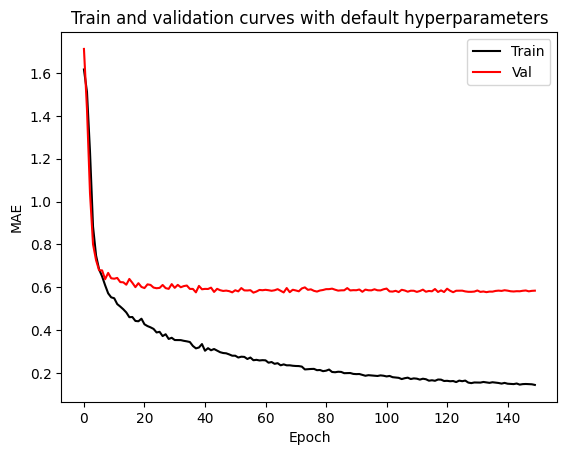

In [51]:
train_mae = pd.read_csv("wandb_export_train.csv")
val_mae = pd.read_csv("wandb_export_val_mae.csv")

plt.title("Train and validation curves with default hyperparameters")
plt.plot(train_mae.iloc[:,0], train_mae.iloc[:,1], c='k', label='Train')
plt.plot(val_mae.iloc[:,0], val_mae.iloc[:,1], c='r', label='Val')
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend(loc='best')
plt.show()

Decreasing the batch size to 36 (from 256) gave some incremental gains, such that the **mean absolute error on the test set was 0.54.**

With more time and compute resources, I would have liked to do a more thorough hyperparameter search, including many of the other optimizer and scheduler hyperparameters. Maybe however, the amount of data is too small even for finetuning on such a large model, and I would also have liked to try the smallest GraphGPS. 

One final note on a small code change I made: when using the `random` option for `data.split_mode` in the configuration file, I noticed the [original code](https://github.com/tz545/EGFR-detection-GraphGPS/blob/main/graphgps/loader/split_generator.py) used a comparison to an integer `sum(split_ratios) != 1`, which threw an error even when the splits sum to 1. I replaced this expression with `abs(1-sum(split_ratios)) > 1E-5` to avoid the error. 